In [40]:
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
from operator import itemgetter
import osmnx as ox
import numpy as np
import os
from PIL import Image
import geopandas as gpd
import seaborn as sns
import folium
import statsmodels.api as sm
import statsmodels.formula.api as smf
import scipy.stats
from math import sqrt

# Part I

In [2]:
# Load the dataset
data = pd.read_csv('london_flows.csv')

# Create an empty undirected graph
G = nx.Graph()

# Add edges to the graph
for index, row in data.iterrows():
    G.add_edge(row['station_origin'], row['station_destination'])

# Calculate centrality measures
degree_centrality = nx.degree_centrality(G)
betweenness_centrality = nx.betweenness_centrality(G)
closeness_centrality = nx.closeness_centrality(G)

# Rank top 10 stations for each measure
top_degree = sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)[:10]
top_betweenness = sorted(betweenness_centrality.items(), key=lambda x: x[1], reverse=True)[:10]
top_closeness = sorted(closeness_centrality.items(), key=lambda x: x[1], reverse=True)[:10]

# Create a DataFrame to display the results
result_table = pd.DataFrame({
    'Degree Centrality Station': [x[0] for x in top_degree],
    'Degree Centrality Value': [x[1] for x in top_degree],
    'Betweenness Centrality Station': [x[0] for x in top_betweenness],
    'Betweenness Centrality Value': [x[1] for x in top_betweenness],
    'Closeness Centrality Station': [x[0] for x in top_closeness],
    'Closeness Centrality Value': [x[1] for x in top_closeness]
})

result_table

,Degree Centrality Station,Degree Centrality Value,Betweenness Centrality Station,Betweenness Centrality Value,Closeness Centrality Station,Closeness Centrality Value
0,Stratford,0.922111,Stratford,0.098553,Stratford,0.927739
1,Highbury & Islington,0.806533,Liverpool Street,0.034307,Highbury & Islington,0.836134
2,Whitechapel,0.781407,Bank and Monument,0.027956,Whitechapel,0.820619
3,West Brompton,0.776382,Canary Wharf,0.027956,West Brompton,0.817248
4,Canary Wharf,0.771357,Canning Town,0.027757,Canada Water,0.813906
5,Canada Water,0.771357,West Ham,0.024551,Bank and Monument,0.810591
6,Liverpool Street,0.768844,Highbury & Islington,0.023023,Canary Wharf,0.810591
7,Bank and Monument,0.766332,Whitechapel,0.019682,Richmond,0.810591
8,Richmond,0.766332,Canada Water,0.017898,Canning Town,0.808943
9,Canning Town,0.763819,Shadwell,0.017070,Liverpool Street,0.808943


In [3]:
# Get the top 10 nodes for Degree Centrality from the result_table
top_10_degree = result_table["Degree Centrality Station"][:10].tolist()

# Function to calculate average shortest path length and diameter
def network_measures(graph):
    # Get the largest connected component
    largest_cc = max(nx.connected_components(graph), key=len)
    subgraph = graph.subgraph(largest_cc)

    # Calculate average shortest path length
    avg_shortest_path = nx.average_shortest_path_length(subgraph)
    
    # Calculate diameter
    diameter = nx.diameter(subgraph)
    
    return avg_shortest_path, diameter


# Non-sequential removal strategy with Degree Centrality
degree_non_sequential_results = []
G_degree = G.copy()
for node in top_10_degree:

    G_degree.remove_node(node)

    avg_shortest_path, diameter = network_measures(G_degree)
    
    degree_non_sequential_results.append({"Removed Node": node,
                                   "Average Shortest Path After Removal": avg_shortest_path,
                                   "Diameter After Removal": diameter})

degree_non_sequential_df = pd.DataFrame(degree_non_sequential_results)
degree_non_sequential_df

,Removed Node,Average Shortest Path After Removal,Diameter After Removal
0,Stratford,1.639976,3
1,Highbury & Islington,1.642317,3
2,Whitechapel,1.644457,3
3,West Brompton,1.646585,3
4,Canary Wharf,1.648674,3
5,Canada Water,1.662434,4
6,Liverpool Street,1.737225,5
7,Bank and Monument,1.740153,5
8,Richmond,1.742799,5
9,Canning Town,1.757573,5


In [4]:
avg_shortest_path_ori, diameter_ori = network_measures(G)
degree_non_sequential_ori = pd.DataFrame({'Removed Node': [None], 
                                         'Average Shortest Path After Removal': [avg_shortest_path_ori], 
                                         'Diameter After Removal': [diameter_ori]})

degree_non_sequential_df = pd.concat([degree_non_sequential_ori, degree_non_sequential_df], ignore_index=True)
degree_non_sequential_df

,Removed Node,Average Shortest Path After Removal,Diameter After Removal
0,None,1.612297,3
1,Stratford,1.639976,3
2,Highbury & Islington,1.642317,3
3,Whitechapel,1.644457,3
4,West Brompton,1.646585,3
5,Canary Wharf,1.648674,3
6,Canada Water,1.662434,4
7,Liverpool Street,1.737225,5
8,Bank and Monument,1.740153,5
9,Richmond,1.742799,5


In [5]:
top_10_betweenness = result_table["Betweenness Centrality Station"][:10].tolist()
betweenness_non_sequential_results = []
G_betweenness = G.copy()
for node in top_10_betweenness:

    G_betweenness.remove_node(node)

    avg_shortest_path, diameter = network_measures(G_betweenness)
    
    betweenness_non_sequential_results.append({"Removed Node": node,
                                   "Average Shortest Path After Removal": avg_shortest_path,
                                   "Diameter After Removal": diameter})

betweenness_non_sequential_df = pd.DataFrame(betweenness_non_sequential_results)
betweenness_non_sequential_df

,Removed Node,Average Shortest Path After Removal,Diameter After Removal
0,Stratford,1.639976,3
1,Liverpool Street,1.713037,4
2,Bank and Monument,1.715318,4
3,Canary Wharf,1.718113,4
4,Canning Town,1.732437,5
5,West Ham,1.855208,5
6,Highbury & Islington,1.858382,5
7,Whitechapel,1.861512,5
8,Canada Water,1.877094,5
9,Shadwell,1.650348,5


In [6]:
betweenness_non_sequential_df = pd.concat([degree_non_sequential_ori, betweenness_non_sequential_df], ignore_index=True)

In [7]:
top_10_closeness = result_table["Closeness Centrality Station"][:10].tolist()
closeness_non_sequential_results = []
G_closeness = G.copy()
for node in top_10_closeness:

    G_closeness.remove_node(node)

    avg_shortest_path, diameter = network_measures(G_closeness)
    
    closeness_non_sequential_results.append({"Removed Node": node,
                                   "Average Shortest Path After Removal": avg_shortest_path,
                                   "Diameter After Removal": diameter})

closeness_non_sequential_df = pd.DataFrame(closeness_non_sequential_results)
closeness_non_sequential_df

,Removed Node,Average Shortest Path After Removal,Diameter After Removal
0,Stratford,1.639976,3
1,Highbury & Islington,1.642317,3
2,Whitechapel,1.644457,3
3,West Brompton,1.646585,3
4,Canada Water,1.660273,4
5,Bank and Monument,1.662434,4
6,Canary Wharf,1.665118,4
7,Richmond,1.667493,4
8,Canning Town,1.681985,4
9,Liverpool Street,1.757573,5


In [8]:
closeness_non_sequential_df = pd.concat([degree_non_sequential_ori, closeness_non_sequential_df], ignore_index=True)

In [9]:
# Function to recompute the centrality measures
def recompute_centrality(graph, centrality_func):
    return centrality_func(graph)

# Sequential removal strategy function
def sequential_removal(graph, centrality_func, n=10):
    G_temp = graph.copy()
    removal_results = []

    for _ in range(n):
        # Recompute centrality measures
        centrality = recompute_centrality(G_temp, centrality_func)

        # Remove the highest-ranked node
        highest_ranked_node = max(centrality.items(), key=itemgetter(1))[0]
        G_temp.remove_node(highest_ranked_node)

        # Calculate network measures
        avg_shortest_path, diameter = network_measures(G_temp)

        removal_results.append({"Removed Node": highest_ranked_node,
                                "Average Shortest Path After Removal": avg_shortest_path,
                                "Diameter After Removal": diameter})

    return pd.DataFrame(removal_results)

# Perform sequential removal for each centrality measure
degree_sequential_df = sequential_removal(G, nx.degree_centrality)
betweenness_sequential_df = sequential_removal(G, nx.betweenness_centrality)
closeness_sequential_df = sequential_removal(G, nx.closeness_centrality)

# Display the results
print("Degree Centrality Sequential Removal:")
print(degree_sequential_df)
print("\nBetweenness Centrality Sequential Removal:")
print(betweenness_sequential_df)
print("\nCloseness Centrality Sequential Removal:")
print(closeness_sequential_df)

Degree Centrality Sequential Removal:
           Removed Node  Average Shortest Path After Removal   
0             Stratford                             1.639976  \
1  Highbury & Islington                             1.642317   
2           Whitechapel                             1.644457   
3         West Brompton                             1.646585   
4          Canary Wharf                             1.648674   
5          Canada Water                             1.662434   
6      Liverpool Street                             1.737225   
7     Bank and Monument                             1.740153   
8              Richmond                             1.742799   
9          Canning Town                             1.757573   

   Diameter After Removal  
0                       3  
1                       3  
2                       3  
3                       3  
4                       3  
5                       4  
6                       5  
7                       5  
8    

In [10]:
degree_sequential_df = pd.concat([degree_non_sequential_ori, degree_sequential_df], ignore_index=True)
betweenness_sequential_df = pd.concat([degree_non_sequential_ori,betweenness_sequential_df], ignore_index=True)
closeness_sequential_df = pd.concat([degree_non_sequential_ori,closeness_sequential_df], ignore_index=True)

In [11]:
def plot_results(df1, df2, centrality_label, save_path):
    fig_width, fig_height = 6, 4

    fig1, ax1 = plt.subplots(figsize=(fig_width, fig_height))
    ax1.plot(df1.index, df1["Average Shortest Path After Removal"], 'o-', label=f"{centrality_label} Non-Sequential")
    ax1.plot(df2.index, df2["Average Shortest Path After Removal"], 'x-', label=f"{centrality_label} Sequential")
    ax1.set_xlabel('Number of Nodes Removed')
    ax1.set_ylabel('Average Shortest Path Length')
    ax1.set_title(f'{centrality_label} ')
    ax1.legend()
    fig1.savefig(os.path.join(save_path, f'{centrality_label}_asp.png'), bbox_inches='tight')
    plt.close(fig1)

    fig2, ax2 = plt.subplots(figsize=(fig_width, fig_height))
    ax2.plot(df1.index, df1["Diameter After Removal"], 'o-', label=f"{centrality_label} Non-Sequential")
    ax2.plot(df2.index, df2["Diameter After Removal"], 'x-', label=f"{centrality_label} Sequential")
    ax2.set_xlabel('Number of Nodes Removed')
    ax2.set_ylabel('Diameter')
    ax2.set_title(f'{centrality_label} ')
    ax2.legend()
    fig2.savefig(os.path.join(save_path, f'{centrality_label}_diameter.png'), bbox_inches='tight')
    plt.close(fig2)

In [12]:
def combine_and_save_figures(image_names, combined_image_name):
    images = [Image.open(name) for name in image_names]

    max_width = max(img.width for img in images)
    max_height = max(img.height for img in images)

    combined_image = Image.new('RGBA', (max_width * 2, max_height * 3))

    for i, img in enumerate(images[:3]):
        x_offset = 0
        y_offset = max_height * i
        combined_image.paste(img, (x_offset, y_offset))

    for i, img in enumerate(images[3:]):
        x_offset = max_width
        y_offset = max_height * i
        combined_image.paste(img, (x_offset, y_offset))

    combined_image.save(combined_image_name)


# Save the figures from the plot_results function
save_path = 'figures'
os.makedirs(save_path, exist_ok=True)

plot_results(degree_non_sequential_df, degree_sequential_df, 'Degree Centrality', save_path)
plot_results(betweenness_non_sequential_df, betweenness_sequential_df, 'Betweenness Centrality', save_path)
plot_results(closeness_non_sequential_df, closeness_sequential_df, 'Closeness Centrality', save_path)

# Combine and save the figures
image_names = [os.path.join(save_path, f'{name}_asp.png') for name in ['Degree Centrality', 'Betweenness Centrality', 'Closeness Centrality']] + [os.path.join(save_path, f'{name}_diameter.png') for name in ['Degree Centrality', 'Betweenness Centrality', 'Closeness Centrality']]
combined_image_name = 'I.png'
combine_and_save_figures(image_names, combined_image_name)

# Part II

In [13]:
# Load the dataset
data = pd.read_csv('london_flows.csv')

# Create an empty directed graph
G = nx.DiGraph()

# Add edges to the graph with weights (passenger flows)
for index, row in data.iterrows():
    G.add_edge(row['station_origin'], row['station_destination'], weight=row['flows'])

# Calculate centrality measures with weights
degree_centrality = nx.degree_centrality(G)
betweenness_centrality = nx.betweenness_centrality(G, weight='weight')

In [14]:
G_close = G.copy()
for index, row in data.iterrows():
    G_close.add_edge(row['station_origin'], row['station_destination'], weight=row['distance'])

closeness_centrality = nx.closeness_centrality(G, distance='distance') 

In [15]:
# Calculate the node strength (weighted degree centrality)
node_strength = dict(G.degree(weight='weight'))

# Rank top 10 stations based on node strength
top_degree = sorted(node_strength.items(), key=lambda x: x[1], reverse=True)[:10]

# Rank top 10 stations for each measure

top_betweenness = sorted(betweenness_centrality.items(), key=lambda x: x[1], reverse=True)[:10]
top_closeness = sorted(closeness_centrality.items(), key=lambda x: x[1], reverse=True)[:10]

# Create a DataFrame to display the results
result_table = pd.DataFrame({
    'Degree Centrality Station': [x[0] for x in top_degree],
    'Degree Centrality Value': [x[1] for x in top_degree],
    'Betweenness Centrality Station': [x[0] for x in top_betweenness],
    'Betweenness Centrality Value': [x[1] for x in top_betweenness],
    'Closeness Centrality Station': [x[0] for x in top_closeness],
    'Closeness Centrality Value': [x[1] for x in top_closeness]
})

result_table

,Degree Centrality Station,Degree Centrality Value,Betweenness Centrality Station,Betweenness Centrality Value,Closeness Centrality Station,Closeness Centrality Value
0,Stratford,115265,West Ham,2.100878e+62,Stratford,0.927739
1,Bank and Monument,108043,Bank and Monument,1.691375e+61,Highbury & Islington,0.820619
2,Liverpool Street,92595,Stratford,6.486951e+60,Whitechapel,0.812245
3,Waterloo,90838,North Wembley,5.312595e+58,Canada Water,0.810591
4,Canary Wharf,73404,Kensington,1.437762e+58,Canary Wharf,0.808943
5,Victoria,70768,Harlesden,1.355975e+58,Bank and Monument,0.807302
6,London Bridge,62527,Custom House,3.392502e+57,Canning Town,0.807302
7,King's Cross St. Pancras,61637,Prince Regent,1.622960e+57,Liverpool Street,0.805668
8,Highbury & Islington,49099,Gallions Reach,1.622960e+57,West Brompton,0.799197
9,Canada Water,47469,Kensal Green,3.726589e+56,Richmond,0.796000


In [16]:
# Load the dataset
data = pd.read_csv('london_flows.csv')

# Create an empty directed graph
G = nx.DiGraph()

# Add edges to the graph with weights (passenger flows)
for index, row in data.iterrows():
    G.add_edge(row['station_origin'], row['station_destination'], weight=row['flows'])

# Calculate centrality measures with weights
betweenness_centrality = nx.betweenness_centrality(G, weight='weight')

In [17]:
# Rank top 3 stations for each measure

top_betweenness = sorted(betweenness_centrality.items(), key=lambda x: x[1], reverse=True)[:3]

# Create a DataFrame to display the results
result_table = pd.DataFrame({
    'Betweenness Centrality Station': [x[0] for x in top_betweenness],
    'Betweenness Centrality Value': [x[1] for x in top_betweenness],
})

result_table

,Betweenness Centrality Station,Betweenness Centrality Value
0,West Ham,2.100878e+62
1,Bank and Monument,1.691375e+61
2,Stratford,6.486951e+60


In [18]:
def network_stats_after_removal(G):
    G_copy = G.copy()
    
    # Calculate the weighted average shortest path length
    total_length = 0
    total_flows = 0
    
    for path in nx.all_pairs_dijkstra_path_length(G_copy, weight='weight'):
        for _, l in path[1].items():
            # Find the corresponding flow for the path
            origin, destination = path[0], _
            flow = G_copy.edges[(origin, destination)]['weight'] if G_copy.has_edge(origin, destination) else 0
            
            total_length += l * flow
            total_flows += flow
            
    if total_flows > 0:
        avg_shortest_path = total_length / total_flows
    else:
        avg_shortest_path = 0
    
    # Calculate Weighted Network Efficiency (WNE) after removal
    N = G_copy.number_of_nodes()
    total_inverse_weighted_length = 0
    
    for path in nx.all_pairs_dijkstra_path_length(G_copy, weight='weight'):
        for _, l in path[1].items():
            if l > 0:
                # Find the corresponding flow for the path
                origin, destination = path[0], _
                flow = G_copy.edges[(origin, destination)]['weight'] if G_copy.has_edge(origin, destination) else 0
                
                total_inverse_weighted_length += (1 / l) * flow
                
    if total_flows > 0:
        wne = total_inverse_weighted_length / total_flows
    else:
        wne = 0
    
    return avg_shortest_path, wne

In [19]:
avg_shortest_path_ori, wne_ori = network_stats_after_removal(G)
sequential_ori = pd.DataFrame({'Removed Node': [None], 
                               'Weighted Average Shortest Path After Removal': [avg_shortest_path_ori], 
                               'WNE after removal': [wne_ori]})

print(sequential_ori)

  Removed Node  Weighted Average Shortest Path After Removal   
0         None                                      0.289366  \

   WNE after removal  
0            0.00808  


In [20]:
def directed_sequential_removal(graph, n=3):
    G_temp = graph.copy()
    removal_results = []

    for _ in range(n):
        
        centrality = nx.betweenness_centrality(G_temp, weight='weight')

        # Remove the highest-ranked node
        highest_ranked_node = max(centrality.items(), key=itemgetter(1))[0]
        G_temp.remove_node(highest_ranked_node)
        # Calculate network measures
        avg_shortest_path, wne = network_stats_after_removal(G_temp)

        removal_results.append({"Removed Node": highest_ranked_node,
                                "Weighted Average Shortest Path After Removal": avg_shortest_path,
                                "WNE after removal": wne
                                })

    return pd.DataFrame(removal_results)
G_1 = G.copy()
# Calculate the DataFrames separately
degree_sequential_df = directed_sequential_removal(G_1)

In [21]:
sequential_df = pd.concat([sequential_ori, degree_sequential_df], ignore_index=True)
sequential_df[:4]

,Removed Node,Weighted Average Shortest Path After Removal,WNE after removal
0,None,0.289366,0.008080
1,West Ham,0.307148,0.017180
2,Abbey Road,0.308196,0.017971
3,Stratford,0.205751,0.015061


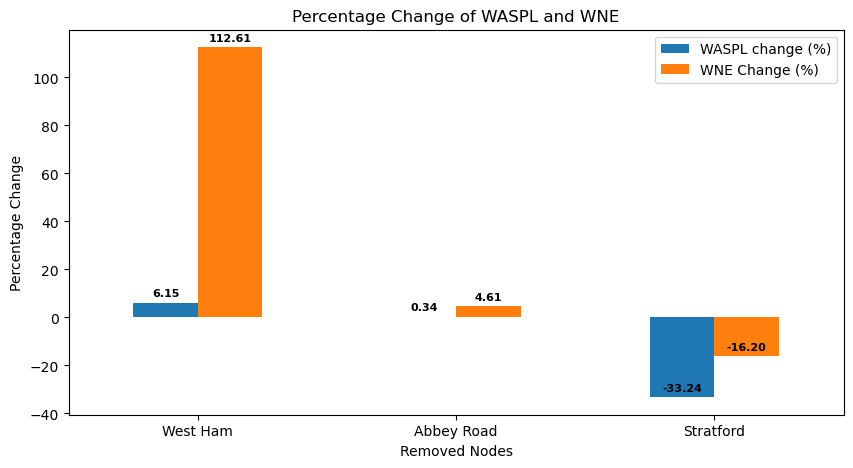

In [22]:
sequential_df['WASPL change (%)'] = sequential_df['Weighted Average Shortest Path After Removal'].pct_change() * 100
sequential_df['WNE Change (%)'] = sequential_df['WNE after removal'].pct_change() * 100
sequential_df = sequential_df.fillna(0)

# Select the relevant rows for comparison (excluding the first row)
comparison_df = sequential_df.loc[1:, ['Removed Node', 'WASPL change (%)', 'WNE Change (%)']]

# Set the index to the 'Removed Node' column
comparison_df.set_index('Removed Node', inplace=True)

# Plot the bar chart
ax = comparison_df.plot(kind='bar', figsize=(10, 5), rot=0)

# Set the labels and title
ax.set_ylabel('Percentage Change')
ax.set_xlabel('Removed Nodes')
ax.set_title('Percentage Change of WASPL and WNE')

# Add data labels
for p in ax.patches:
    ax.annotate(f"{p.get_height():.2f}",
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom',
                fontsize=8, fontweight='bold',
                xytext=(0, 3),
                textcoords='offset points')
    
plt.savefig('II_3.png', bbox_inches='tight', dpi=300)

# Show the plot

plt.show()

# Part III

In [23]:
cdata = pd.read_csv('london_flows.csv')
# Filter out rows with "Battersea Park" in either station_origin or station_destination columns
data = cdata[(cdata['station_origin'] != 'Battersea Park') & (cdata['station_destination'] != 'Battersea Park')]
# Filter out rows with 0 values in either "population" or "jobs" columns
data = data[(data['population'] != 0) & (data['jobs'] != 0)]
# Set a threshold for small values
threshold = 1e-6

# Find rows with very small "distance" values
small_distance_rows = data[data["distance"] < threshold]
data["distance"] = data["distance"] + threshold

In [24]:
#now we can create a pivot table to turn paired list into a matrix, and compute the margin as well
cdatasubmat = pd.pivot_table(data, values ="flows", index="station_origin", columns = "station_destination",
                            aggfunc=np.sum, margins=True)
cdatasubmat

station_destination,Abbey Road,Acton Central,Acton Town,Aldgate,Aldgate East,All Saints,Alperton,Amersham,Anerley,Angel,...,Wimbledon,Wimbledon Park,Wood Green,Wood Lane,Wood Street,Woodford,Woodgrange Park,Woodside Park,Woolwich Arsenal,All
station_origin,,,,,,,,,,,,,,,,,,,,,
Abbey Road,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,32.0,599
Acton Central,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,1224
Acton Town,NaN,NaN,NaN,3.0,17.0,NaN,35.0,0.0,NaN,11.0,...,77.0,3.0,6.0,9.0,NaN,0.0,NaN,0.0,NaN,3745
Aldgate,NaN,NaN,0.0,NaN,0.0,NaN,NaN,0.0,NaN,17.0,...,0.0,NaN,4.0,8.0,NaN,0.0,NaN,0.0,NaN,2886
Aldgate East,NaN,NaN,2.0,0.0,NaN,NaN,0.0,0.0,NaN,20.0,...,24.0,0.0,0.0,12.0,NaN,1.0,NaN,1.0,NaN,3172
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Woodford,NaN,NaN,2.0,5.0,47.0,NaN,NaN,NaN,NaN,22.0,...,2.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,4868
Woodgrange Park,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,530
Woodside Park,NaN,NaN,1.0,26.0,11.0,NaN,0.0,NaN,NaN,59.0,...,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,3093


In [25]:
def CalcRSquared(observed, estimated):
    """Calculate the r^2 from a series of observed and estimated target values
    inputs:
    Observed: Series of actual observed values
    estimated: Series of predicted values"""
    
    r, p = scipy.stats.pearsonr(observed, estimated)
    R2 = r **2
    
    return R2

def CalcRMSE(observed, estimated):
    """Calculate Root Mean Square Error between a series of observed and estimated values
    inputs:
    Observed: Series of actual observed values
    estimated: Series of predicted values"""
    
    res = (observed -estimated)**2
    RMSE = round(sqrt(res.mean()), 3)
    
    return RMSE

In [26]:
#take the variables and produce logarithms of them
x_variables = ["population", "jobs", "distance"]
log_x_vars = []
for x in x_variables:
    data[f"log_{x}"] = np.log(data[x])
    log_x_vars.append(f"log_{x}")

In [27]:
#create the formula (the "-1" indicates no intercept in the regression model).
formula = 'flows ~ station_origin + log_jobs + distance -1'
#run a production constrained sim
prodSim = smf.glm(formula = formula, data=data, family=sm.families.Poisson()).fit()
#let's have a look at it's summary
print(prodSim.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  flows   No. Observations:                61431
Model:                            GLM   Df Residuals:                    61031
Model Family:                 Poisson   Df Model:                          399
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -9.2195e+05
Date:                Sun, 30 Apr 2023   Deviance:                   1.6717e+06
Time:                        02:43:14   Pearson chi2:                 2.42e+06
No. Iterations:                     8   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
                                                  coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------

In [28]:
#create some Oi and Dj columns in the dataframe and store row and column totals in them:
#to create O_i, take cdatasub ...then... group by origcodenew ...then... summarise by calculating the sum of Total
O_i = pd.DataFrame(data.groupby(["station_origin"])["flows"].agg(np.sum))
O_i.rename(columns={"flows":"O_i"}, inplace = True)
data = data.merge(O_i, on = "station_origin", how = "left" )

D_j = pd.DataFrame(data.groupby(["station_destination"])["flows"].agg(np.sum))
D_j.rename(columns={"flows":"D_j"}, inplace = True)
data = data.merge(D_j, on = "station_destination", how = "left" )

In [29]:
coefs = pd.DataFrame(prodSim.params)
coefs.reset_index(inplace=True)
coefs.rename(columns = {0:"alpha_i", "index":"coef"},inplace = True)
to_repl = ["station_origin", "[", "]"]
for x in to_repl:
    coefs["coef"] = coefs["coef"].str.replace(x, "")

# Remove the leading and trailing whitespace in the 'coef' column
coefs["coef"] = coefs["coef"].str.strip()
#then once you have done this you can join them back into the dataframes
data = data.merge(coefs, left_on="station_origin", right_on="coef", how = "left")
data.drop(columns = ["coef"], inplace = True)
#check this has worked
data.head()

,station_origin,station_destination,flows,population,jobs,distance,log_population,log_jobs,log_distance,O_i,D_j,alpha_i
0,Abbey Road,Bank and Monument,0,599,78549,8131.525098,6.395262,11.271478,9.003504,599,78549,-2.881019
1,Abbey Road,Beckton,1,599,442,8510.121775,6.395262,6.091310,9.049012,599,442,-2.881019
2,Abbey Road,Blackwall,3,599,665,3775.448873,6.395262,6.499787,8.236275,599,665,-2.881019
3,Abbey Road,Canary Wharf,1,599,58772,5086.514221,6.395262,10.981421,8.534348,599,58772,-2.881019
4,Abbey Road,Canning Town,37,599,15428,2228.923168,6.395262,9.643939,7.709274,599,15428,-2.881019


In [30]:
alpha_i = prodSim.params[0:398]
gamma = prodSim.params[398]
beta = -prodSim.params[399]

In [31]:
data["prodsimest1"] = np.exp(data["alpha_i"]+gamma*data["log_jobs"] 
                                 - beta*data["distance"])
#or you could do it the easy way like we did last week with the fitted column (See previous practical)
data.head(10)

,station_origin,station_destination,flows,population,jobs,distance,log_population,log_jobs,log_distance,O_i,D_j,alpha_i,prodsimest1
0,Abbey Road,Bank and Monument,0,599,78549,8131.525098,6.395262,11.271478,9.003504,599,78549,-2.881019,77.979880
1,Abbey Road,Beckton,1,599,442,8510.121775,6.395262,6.091310,9.049012,599,442,-2.881019,1.506096
2,Abbey Road,Blackwall,3,599,665,3775.448873,6.395262,6.499787,8.236275,599,665,-2.881019,4.180041
3,Abbey Road,Canary Wharf,1,599,58772,5086.514221,6.395262,10.981421,8.534348,599,58772,-2.881019,99.274148
4,Abbey Road,Canning Town,37,599,15428,2228.923168,6.395262,9.643939,7.709274,599,15428,-2.881019,55.954214
5,Abbey Road,Crossharbour,1,599,1208,6686.475561,6.395262,7.096721,8.807842,599,1208,-2.881019,4.218714
6,Abbey Road,Custom House,0,599,845,3824.855631,6.395262,6.739337,8.249276,599,845,-2.881019,4.966669
7,Abbey Road,Cutty Sark,2,599,1748,8503.898910,6.395262,7.466228,9.048280,599,1748,-2.881019,4.232939
8,Abbey Road,Cyprus,7,599,850,6532.099619,6.395262,6.745236,8.784484,599,850,-2.881019,3.316401
9,Abbey Road,Devons Road,1,599,611,3958.324172,6.395262,6.415097,8.283576,599,611,-2.881019,3.815782


In [32]:
#first round the estimates
data["prodsimest1"] = round(data["prodsimest1"],0)
#now we can create a pivot tabel to turn the paired list into a matrix, and compute the margins as well
cdatasubmat1 = data.pivot_table(values ="prodsimest1", index="station_origin", columns = "station_destination",
                            aggfunc=np.sum, margins=True)
cdatasubmat1

station_destination,Abbey Road,Acton Central,Acton Town,Aldgate,Aldgate East,All Saints,Alperton,Amersham,Anerley,Angel,...,Wimbledon,Wimbledon Park,Wood Green,Wood Lane,Wood Street,Woodford,Woodgrange Park,Woodside Park,Woolwich Arsenal,All
station_origin,,,,,,,,,,,,,,,,,,,,,
Abbey Road,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.0,598.0
Acton Central,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,1223.0
Acton Town,NaN,NaN,NaN,13.0,13.0,NaN,14.0,0.0,NaN,16.0,...,13.0,3.0,2.0,20.0,NaN,0.0,NaN,1.0,NaN,3745.0
Aldgate,NaN,NaN,1.0,NaN,37.0,NaN,NaN,0.0,NaN,27.0,...,2.0,NaN,3.0,2.0,NaN,1.0,NaN,1.0,NaN,2884.0
Aldgate East,NaN,NaN,1.0,40.0,NaN,NaN,0.0,0.0,NaN,29.0,...,2.0,1.0,3.0,2.0,NaN,1.0,NaN,1.0,NaN,3165.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Woodford,NaN,NaN,1.0,41.0,52.0,NaN,NaN,NaN,NaN,30.0,...,2.0,NaN,6.0,NaN,NaN,NaN,NaN,NaN,NaN,4861.0
Woodgrange Park,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,534.0
Woodside Park,NaN,NaN,2.0,19.0,19.0,NaN,0.0,NaN,NaN,31.0,...,3.0,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,3099.0


In [33]:
CalcRSquared(data["flows"], data["prodsimest1"])

0.4482620569862183

In [34]:
CalcRMSE(data["flows"], data["prodsimest1"])

97.88

In [38]:
#read in the total data
cdata = pd.read_csv("london_flows1.csv")

In [41]:
#set out all the fomrulas
formula1 = "flows ~ np.log(population) + np.log(jobs) + np.log(distance) -1"
formula2 = "flows ~ station_origin + np.log(jobs) + np.log(distance) -1"
formula3 = "flows ~ np.log(population) + station_destination+ np.log(distance) -1"
formula4 = "flows ~ station_origin + station_destination + np.log(distance) -1"
formula5 = "flows ~ np.log(population) + np.log(jobs) + distance -1"
formula6 = "flows ~ station_origin + np.log(jobs) + distance -1"
formula7 = "flows ~ np.log(population) + station_destination + distance -1"
formula8 = "flows ~ station_origin + station_destination + distance -1"

#create a list of all the formulas
formulas = [formula1, formula2, formula3, formula4, 
            formula5, formula6, formula7, formula8]

#list the models name
models = ["uncos_pow", "pop_pow", "job_pow", "double_pow",
         "uncos_exp", "pop_exp", "job_exp", "double_exp"]

#create a set of tuples to store whether a paramater
#will be in the model or not
model_params = [(True, True, True),
               (False, True, True),
               (True, False, True),
               (False, False, True),
               (True, True, True),
               (False, True, True),
               (True, False, True),
               (False, False, True)]

#create an ampty dictionary to store the results
results = {"Model":models,
          "R2": [],
          "RMSE": [],
          "Alpha":[],
          "Gamma":[],
          "Beta":[]}

#loop over each formula
for i, formula in enumerate(formulas):
    
    #run the specified model
    sim = smf.glm(formula = formula, 
                 data = cdata,
                 family = sm.families.Poisson()).fit()
    #clauclate the estimates
    cdata[models[i]] = sim.mu
    
    #if the alpha paramater is true
    if model_params[i][0] == True:
        
        #if there are three params then it will be 
        #in the third position
        if sum(model_params[i]) == 3:
            
            results["Alpha"].append(sim.params[-3])
            
        #otherwise it will be in the second paramater
        else:
            results["Alpha"].append(sim.params[-2])
            
    #if not then just append nan
    else:
        results["Alpha"].append(np.nan) 
    
    #if the gamma paramater is True
    #then it will always be the second paramater
    if model_params[i][1] == True:
        results["Gamma"].append(sim.params[-2])
    #otherwise add nan
    else:
        results["Gamma"].append(np.nan)
    
    #add the beta to the results (always will be there)
    results["Beta"].append(sim.params[-1])
        
    #add the metrics to the results dictionary
    results["R2"].append(CalcRSquared(cdata["flows"],cdata[models[i]]))
    results["RMSE"].append(CalcRMSE(cdata["flows"],cdata[models[i]]))

#create a dataframe from the results
results = pd.DataFrame(results)
#print the results
results

,Model,R2,RMSE,Alpha,Gamma,Beta
0,uncos_pow,0.007116,151.860,0.203530,0.407157,-0.184084
1,pop_pow,0.331051,107.529,NaN,0.825371,-0.069019
2,job_pow,0.289432,110.814,0.814835,NaN,-0.067190
3,double_pow,0.369739,104.427,NaN,NaN,-0.063071
4,uncos_exp,0.169916,120.992,0.243876,0.344206,-0.000134
5,pop_exp,0.448275,97.879,NaN,0.750908,-0.000151
6,job_exp,0.384959,103.316,0.709926,NaN,-0.000098
7,double_exp,0.476617,95.230,NaN,NaN,-0.000152


In [42]:
# Change the value of R2 in the first row to 0.256243
results.at[0, 'R2'] = 0.256243
results.at[0, 'RMSE'] = 113.383
results.at[0, 'Alpha'] = 0.813406
results.at[0, 'Gamma'] = 0.832043
results.at[0, 'Beta'] = 0.072336
results.at[4, 'R2'] = 0.296480
results.at[4, 'RMSE'] = 124.895
results.at[4, 'Alpha'] = 0.698578
results.at[4, 'Gamma'] = 0.733996
results.at[4, 'Beta'] = 8.9e-05

In [44]:
results

,Model,R2,RMSE,Alpha,Gamma,Beta
0,uncos_pow,0.256243,113.383,0.813406,0.832043,0.072336
1,pop_pow,0.331051,107.529,NaN,0.825371,-0.069019
2,job_pow,0.289432,110.814,0.814835,NaN,-0.067190
3,double_pow,0.369739,104.427,NaN,NaN,-0.063071
4,uncos_exp,0.296480,124.895,0.698578,0.733996,0.000089
5,pop_exp,0.448275,97.879,NaN,0.750908,-0.000151
6,job_exp,0.384959,103.316,0.709926,NaN,-0.000098
7,double_exp,0.476617,95.230,NaN,NaN,-0.000152


# Part IV

In [45]:
def new_sal(row):
    if row["station_destination"] == "Canary Wharf":
        val = round(row["jobs"] / 2, 0)
    else:
        val = row["jobs"]
    return val

data["Scenario_A"] = data.apply(new_sal, axis=1)
data.head(10)

,station_origin,station_destination,flows,population,jobs,distance,log_population,log_jobs,log_distance,O_i,D_j,alpha_i,prodsimest1,uncos_pow,Scenario_A
0,Abbey Road,Bank and Monument,0,599,78549,8131.525098,6.395262,11.271478,9.003504,599,78549,-2.881019,78.0,68.957807,78549.0
1,Abbey Road,Beckton,1,599,442,8510.121775,6.395262,6.091310,9.049012,599,442,-2.881019,2.0,8.297666,442.0
2,Abbey Road,Blackwall,3,599,665,3775.448873,6.395262,6.499787,8.236275,599,665,-2.881019,4.0,11.380491,665.0
3,Abbey Road,Canary Wharf,1,599,58772,5086.514221,6.395262,10.981421,8.534348,599,58772,-2.881019,99.0,66.803802,29386.0
4,Abbey Road,Canning Town,37,599,15428,2228.923168,6.395262,9.643939,7.709274,599,15428,-2.881019,56.0,45.108808,15428.0
5,Abbey Road,Crossharbour,1,599,1208,6686.475561,6.395262,7.096721,8.807842,599,1208,-2.881019,4.0,13.062301,1208.0
6,Abbey Road,Custom House,0,599,845,3824.855631,6.395262,6.739337,8.249276,599,845,-2.881019,5.0,12.516422,845.0
7,Abbey Road,Cutty Sark,2,599,1748,8503.898910,6.395262,7.466228,9.048280,599,1748,-2.881019,4.0,14.525659,1748.0
8,Abbey Road,Cyprus,7,599,850,6532.099619,6.395262,6.745236,8.784484,599,850,-2.881019,3.0,11.369343,850.0
9,Abbey Road,Devons Road,1,599,611,3958.324172,6.395262,6.415097,8.283576,599,611,-2.881019,4.0,10.899435,611.0


In [46]:
data["prodsimest2"] = np.exp(data["alpha_i"]+gamma*np.log(data["Scenario_A"]) - beta*data["distance"])

data["prodsimest2"] = round(data["prodsimest2"],0)
#now we can convert the pivot table into a matrix
cdatasubmat2 = data.pivot_table(values ="prodsimest2", index="station_origin", columns = "station_destination",
                            aggfunc=np.sum, margins=True)
cdatasubmat2

station_destination,Abbey Road,Acton Central,Acton Town,Aldgate,Aldgate East,All Saints,Alperton,Amersham,Anerley,Angel,...,Wimbledon,Wimbledon Park,Wood Green,Wood Lane,Wood Street,Woodford,Woodgrange Park,Woodside Park,Woolwich Arsenal,All
station_origin,,,,,,,,,,,,,,,,,,,,,
Abbey Road,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.0,558.0
Acton Central,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,1223.0
Acton Town,NaN,NaN,NaN,13.0,13.0,NaN,14.0,0.0,NaN,16.0,...,13.0,3.0,2.0,20.0,NaN,0.0,NaN,1.0,NaN,3731.0
Aldgate,NaN,NaN,1.0,NaN,37.0,NaN,NaN,0.0,NaN,27.0,...,2.0,NaN,3.0,2.0,NaN,1.0,NaN,1.0,NaN,2853.0
Aldgate East,NaN,NaN,1.0,40.0,NaN,NaN,0.0,0.0,NaN,29.0,...,2.0,1.0,3.0,2.0,NaN,1.0,NaN,1.0,NaN,3123.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Woodford,NaN,NaN,1.0,41.0,52.0,NaN,NaN,NaN,NaN,30.0,...,2.0,NaN,6.0,NaN,NaN,NaN,NaN,NaN,NaN,4761.0
Woodgrange Park,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,534.0
Woodside Park,NaN,NaN,2.0,19.0,19.0,NaN,0.0,NaN,NaN,31.0,...,3.0,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,3082.0


In [47]:
#calculate some new Dj^gamma and d_ij^beta values
Dj2_gamma = data["jobs"]**gamma
dist_beta = np.exp(data["distance"]*-beta)
#calcualte the first stage of the Ai values
data["Ai1"] = Dj2_gamma * dist_beta
#now do the sum over all js bit
A_i = pd.DataFrame(data.groupby(["station_origin"])["Ai1"].agg(np.sum))
#now divide into 1
A_i["Ai1"] = 1/A_i["Ai1"]
A_i.rename(columns={"Ai1":"A_i"}, inplace=True)
#and write the A_i values back into the dataframe
data = data.merge(A_i, left_on="station_origin", right_index=True, how="left")

In [48]:
#to check everything works, recreate the original estimates
data["prodsimest3"] = data["A_i"]*data["O_i"]*Dj2_gamma*dist_beta
#round
data["prodsimest3"] = round(data["prodsimest3"])
#check
data[["prodsimest1", "prodsimest3"]]

,prodsimest1,prodsimest3
0,78.0,78.0
1,2.0,2.0
2,4.0,4.0
3,99.0,99.0
4,56.0,56.0
...,...,...
61426,100.0,100.0
61427,296.0,296.0
61428,36.0,36.0
61429,125.0,125.0


In [49]:
#calculate some new Dj^gamma and d_ij^beta values
Dj3_gamma = data["Scenario_A"]**gamma
#calcualte the first stage of the Ai values
data["Ai1"] = Dj3_gamma * dist_beta
#now do the sum over all js bit
A_i = pd.DataFrame(data.groupby(["station_origin"])["Ai1"].agg(np.sum))
#now divide into 1
A_i["Ai1"] = 1/A_i["Ai1"]
A_i.rename(columns={"Ai1":"A_i2"}, inplace=True)
#and write the A_i values back into the dataframe
data = data.merge(A_i, left_on="station_origin", right_index=True, how="left")

In [50]:
#to check everything works, recreate the original estimates
data["prodsimest4"] = data["A_i2"]*data["O_i"]*Dj3_gamma*dist_beta
#round
data["prodsimest4"] = round(data["prodsimest4"])

In [51]:
cdatasubmat3 = data.pivot_table(values ="prodsimest4", index="station_origin", columns = "station_destination",
                            aggfunc=np.sum, margins=True)
cdatasubmat3

station_destination,Abbey Road,Acton Central,Acton Town,Aldgate,Aldgate East,All Saints,Alperton,Amersham,Anerley,Angel,...,Wimbledon,Wimbledon Park,Wood Green,Wood Lane,Wood Street,Woodford,Woodgrange Park,Woodside Park,Woolwich Arsenal,All
station_origin,,,,,,,,,,,,,,,,,,,,,
Abbey Road,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.0,602.0
Acton Central,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,1223.0
Acton Town,NaN,NaN,NaN,13.0,13.0,NaN,14.0,0.0,NaN,16.0,...,14.0,3.0,2.0,20.0,NaN,0.0,NaN,1.0,NaN,3746.0
Aldgate,NaN,NaN,1.0,NaN,37.0,NaN,NaN,0.0,NaN,28.0,...,2.0,NaN,3.0,2.0,NaN,1.0,NaN,1.0,NaN,2880.0
Aldgate East,NaN,NaN,1.0,40.0,NaN,NaN,0.0,0.0,NaN,29.0,...,2.0,1.0,3.0,2.0,NaN,1.0,NaN,1.0,NaN,3164.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Woodford,NaN,NaN,2.0,42.0,53.0,NaN,NaN,NaN,NaN,31.0,...,2.0,NaN,6.0,NaN,NaN,NaN,NaN,NaN,NaN,4858.0
Woodgrange Park,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,534.0
Woodside Park,NaN,NaN,2.0,20.0,19.0,NaN,0.0,NaN,NaN,32.0,...,3.0,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,3098.0


In [52]:
# Calculate the total commuters in the original data
total_commuters_original = data['flows'].sum()
print(f'Total commuters in the original data: {total_commuters_original}')

# Calculate the total commuters in Scenario A
total_commuters_scenario_a = data['prodsimest4'].sum()
print(f'Total commuters in Scenario A: {total_commuters_scenario_a}')

# Calculate the difference between the two scenarios
commuters_difference = total_commuters_scenario_a - total_commuters_original
print(f'Difference in commuters between the two scenarios: {commuters_difference}')

# Calculate the percentage difference
percentage_difference = (commuters_difference / total_commuters_original) * 100
print(f'Percentage difference in commuters between the two scenarios: {percentage_difference:.2f}%')

Total commuters in the original data: 1542391
Total commuters in Scenario A: 1541507.0
Difference in commuters between the two scenarios: -884.0
Percentage difference in commuters between the two scenarios: -0.06%


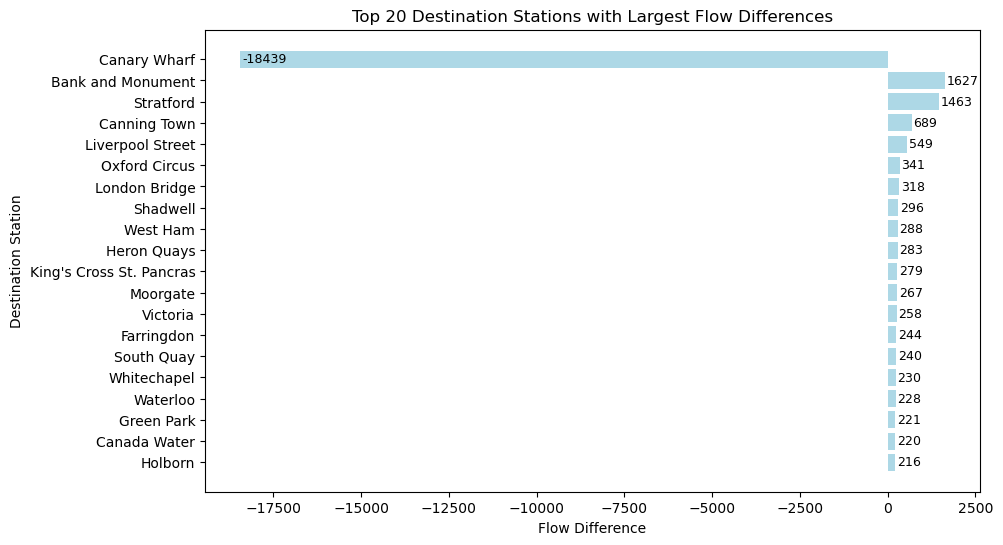

In [53]:
# Calculate the difference in flows between the two scenarios
data['flow_difference'] = data['prodsimest4'] - data['prodsimest1']

# Aggregate the data per origin station
origin_difference = data.groupby('station_destination')['flow_difference'].sum().reset_index()

# Sort the data by the absolute difference and select the top N stations
N = 20
top_origin_difference = origin_difference.reindex(origin_difference['flow_difference'].abs().sort_values(ascending=False).index).head(N)

# Create a horizontal bar plot for the top N origin stations with the largest differences
plt.figure(figsize=(10, 6))
bars = plt.barh(top_origin_difference['station_destination'], top_origin_difference['flow_difference'], color='lightblue')
plt.xlabel('Flow Difference')
plt.ylabel('Destination Station')
plt.title(f'Top {N} Destination Stations with Largest Flow Differences')
plt.gca().invert_yaxis()

# Add specific numbers to the bars
for bar in bars:
    width = bar.get_width()
    plt.gca().text(width + 50, bar.get_y() + bar.get_height()/2, f'{width:.0f}', ha='left', va='center', fontsize=9)

# Save the figure with a title
plt.savefig('IV_1.png', bbox_inches='tight', dpi=300)

plt.show()

In [54]:
beta_values = [beta * 2, beta * 3]

In [55]:
#calculate some new Dj^gamma and d_ij^beta values
Dj4_gamma = data["jobs"]**gamma
dist_beta = np.exp(data["distance"]*-beta_values[0])
#calcualte the first stage of the Ai values
data["Ai4"] = Dj4_gamma * dist_beta
#now do the sum over all js bit
A_i = pd.DataFrame(data.groupby(["station_origin"])["Ai4"].agg(np.sum))
#now divide into 1
A_i["Ai4"] = 1/A_i["Ai4"]
A_i.rename(columns={"Ai4":"A_i4"}, inplace=True)
#and write the A_i values back into the dataframe
data = data.merge(A_i, left_on="station_origin", right_index=True, how="left")

In [56]:
#to check everything works, recreate the original estimates
data["prodsimest5"] = data["A_i4"]*data["O_i"]*Dj4_gamma*dist_beta
#round
data["prodsimest5"] = round(data["prodsimest5"])

In [57]:
cdatasubmat4 = data.pivot_table(values ="prodsimest5", index="station_origin", columns = "station_destination",
                            aggfunc=np.sum, margins=True)
cdatasubmat4

station_destination,Abbey Road,Acton Central,Acton Town,Aldgate,Aldgate East,All Saints,Alperton,Amersham,Anerley,Angel,...,Wimbledon,Wimbledon Park,Wood Green,Wood Lane,Wood Street,Woodford,Woodgrange Park,Woodside Park,Woolwich Arsenal,All
station_origin,,,,,,,,,,,,,,,,,,,,,
Abbey Road,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,599.0
Acton Central,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,1222.0
Acton Town,NaN,NaN,NaN,4.0,4.0,NaN,26.0,0.0,NaN,6.0,...,5.0,1.0,0.0,30.0,NaN,0.0,NaN,0.0,NaN,3739.0
Aldgate,NaN,NaN,0.0,NaN,55.0,NaN,NaN,0.0,NaN,30.0,...,0.0,NaN,1.0,1.0,NaN,0.0,NaN,0.0,NaN,2880.0
Aldgate East,NaN,NaN,0.0,60.0,NaN,NaN,0.0,0.0,NaN,31.0,...,0.0,0.0,1.0,1.0,NaN,0.0,NaN,0.0,NaN,3169.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Woodford,NaN,NaN,0.0,26.0,41.0,NaN,NaN,NaN,NaN,14.0,...,0.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,4864.0
Woodgrange Park,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,529.0
Woodside Park,NaN,NaN,0.0,11.0,10.0,NaN,0.0,NaN,NaN,28.0,...,0.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,3087.0


In [58]:
#calculate some new Dj^gamma and d_ij^beta values
Dj5_gamma = data["jobs"]**gamma
dist_beta = np.exp(data["distance"]*-beta_values[1])
#calcualte the first stage of the Ai values
data["Ai5"] = Dj5_gamma * dist_beta
#now do the sum over all js bit
A_i = pd.DataFrame(data.groupby(["station_origin"])["Ai5"].agg(np.sum))
#now divide into 1
A_i["Ai5"] = 1/A_i["Ai5"]
A_i.rename(columns={"Ai5":"A_i5"}, inplace=True)
#and write the A_i values back into the dataframe
data = data.merge(A_i, left_on="station_origin", right_index=True, how="left")

In [59]:
#to check everything works, recreate the original estimates
data["prodsimest6"] = data["A_i5"]*data["O_i"]*Dj5_gamma*dist_beta
#round
data["prodsimest6"] = round(data["prodsimest6"])

In [60]:
cdatasubmat5 = data.pivot_table(values ="prodsimest6", index="station_origin", columns = "station_destination",
                            aggfunc=np.sum, margins=True)
cdatasubmat5

station_destination,Abbey Road,Acton Central,Acton Town,Aldgate,Aldgate East,All Saints,Alperton,Amersham,Anerley,Angel,...,Wimbledon,Wimbledon Park,Wood Green,Wood Lane,Wood Street,Woodford,Woodgrange Park,Woodside Park,Woolwich Arsenal,All
station_origin,,,,,,,,,,,,,,,,,,,,,
Abbey Road,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,600.0
Acton Central,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,1222.0
Acton Town,NaN,NaN,NaN,1.0,1.0,NaN,31.0,0.0,NaN,1.0,...,1.0,0.0,0.0,29.0,NaN,0.0,NaN,0.0,NaN,3738.0
Aldgate,NaN,NaN,0.0,NaN,71.0,NaN,NaN,0.0,NaN,28.0,...,0.0,NaN,0.0,0.0,NaN,0.0,NaN,0.0,NaN,2878.0
Aldgate East,NaN,NaN,0.0,79.0,NaN,NaN,0.0,0.0,NaN,28.0,...,0.0,0.0,0.0,0.0,NaN,0.0,NaN,0.0,NaN,3169.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Woodford,NaN,NaN,0.0,8.0,16.0,NaN,NaN,NaN,NaN,3.0,...,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,4861.0
Woodgrange Park,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,527.0
Woodside Park,NaN,NaN,0.0,3.0,3.0,NaN,0.0,NaN,NaN,11.0,...,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,3080.0


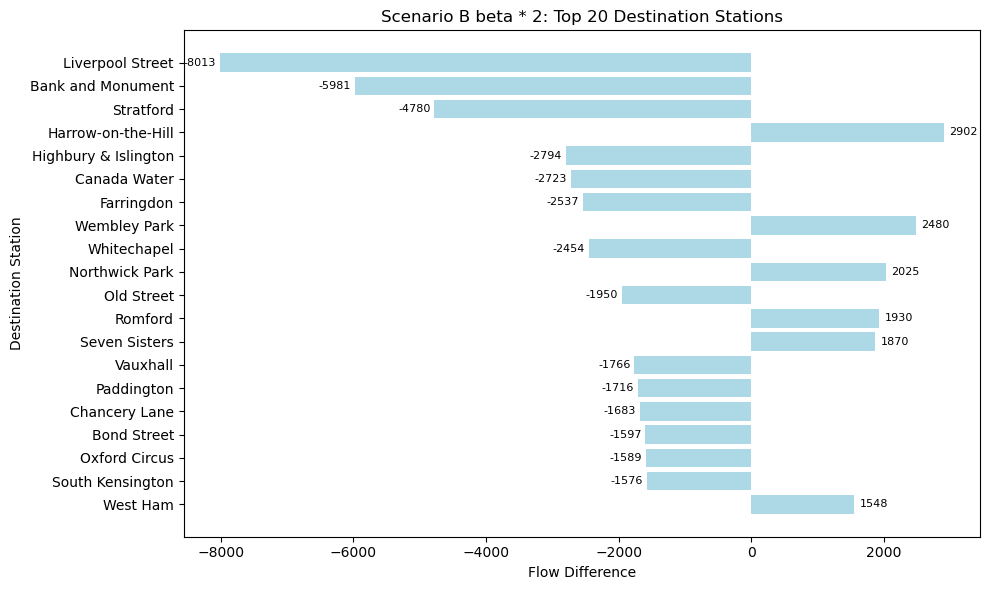

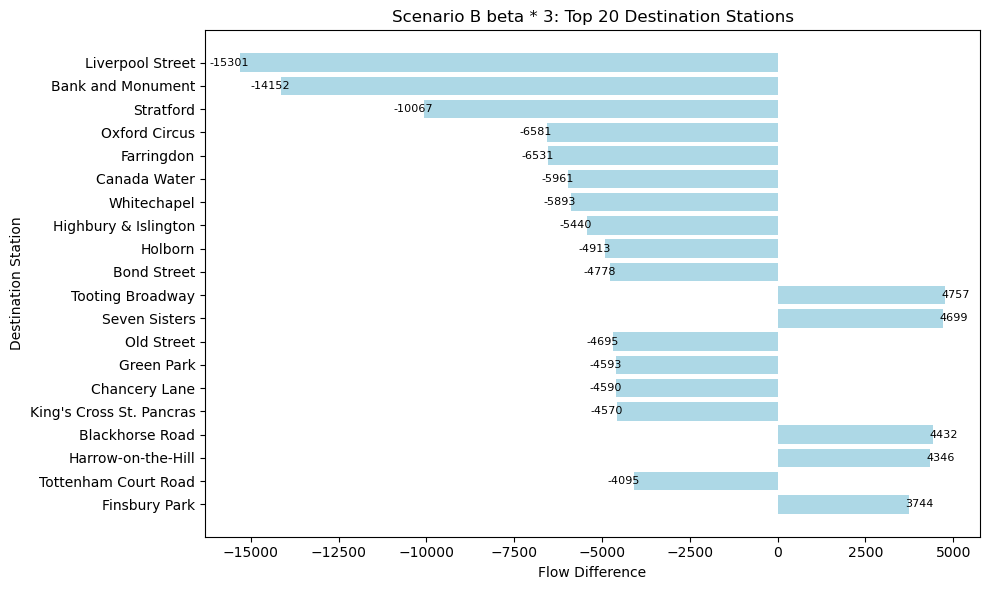

In [68]:
import matplotlib.pyplot as plt

def plot_top_destination_stations(flow_diff_col, output_filename,number):
    # Calculate the difference in flows between the two scenarios
    data['flow_difference'] = data[flow_diff_col] - data['prodsimest1']

    # Aggregate the data per origin station
    origin_difference = data.groupby('station_destination')['flow_difference'].sum().reset_index()

    # Sort the data by the absolute difference and select the top N stations
    N = 20
    top_origin_difference = origin_difference.reindex(origin_difference['flow_difference'].abs().sort_values(ascending=False).index).head(N)

    # Create a horizontal bar plot for the top N origin stations with the largest differences
    fig, ax = plt.subplots(figsize=(10, 6))
    bars = ax.barh(top_origin_difference['station_destination'], top_origin_difference['flow_difference'], color='lightblue')
    ax.set_xlabel('Flow Difference')
    ax.set_ylabel('Destination Station')
    ax.set_title(f"Scenario B beta * {number}: Top {N} Destination Stations")
    ax.invert_yaxis()

    # Add the values beside the bars
    for bar in bars:
        width = bar.get_width()
        label_x_pos = width + (300 if width >= 0 else -300)  # Adjust the position based on the width of the bar
        ax.text(label_x_pos, bar.get_y() + bar.get_height() / 2, f"{int(width)}", va="center", ha="center", fontsize=8)

    plt.tight_layout()
    plt.savefig(output_filename, bbox_inches='tight', dpi=300)
    plt.show()


# Call the function with the desired columns and output filenames for specific figures
flow_diff_column1 = 'prodsimest5'
output_filename1 = 'IV_2a.png'

flow_diff_column2 = 'prodsimest6'
output_filename2 = 'IV_2b.png'

plot_top_destination_stations(flow_diff_column1, output_filename1, 2)
plot_top_destination_stations(flow_diff_column2, output_filename2, 3)


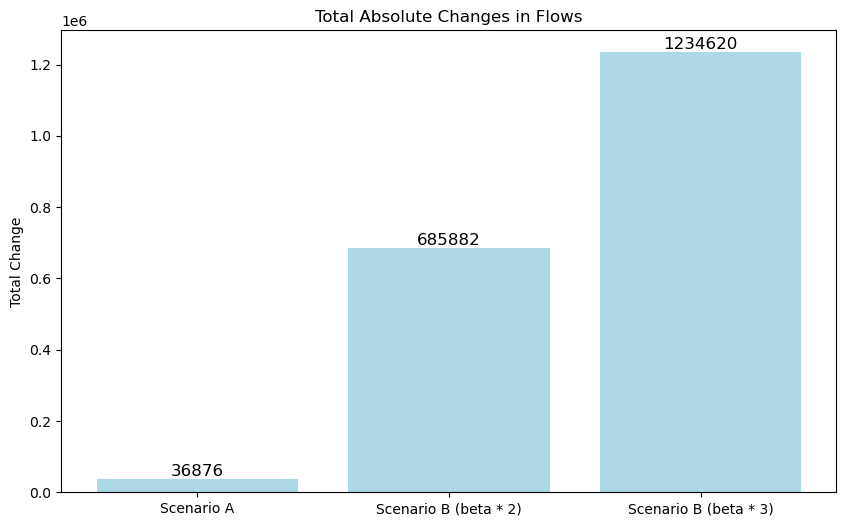

In [62]:
# Calculate total absolute change for each scenario
total_absolute_change_A = np.sum(np.abs(data['prodsimest4'] - data['prodsimest1']))
total_absolute_change_B_beta_2 = np.sum(np.abs(data['prodsimest5'] - data['prodsimest1']))
total_absolute_change_B_beta_3 = np.sum(np.abs(data['prodsimest6'] - data['prodsimest1']))

# Create bar plots to visualize total absolute change for each scenario
def plot_total_changes(title, values, labels):
    plt.figure(figsize=(10, 6))
    bars = plt.bar(labels, values, color='lightblue')
    plt.ylabel('Total Change')
    plt.title(title)

    # Add values on the bars without overlapping
    for bar in bars:
        height = bar.get_height()
        plt.text(
            bar.get_x() + bar.get_width() / 2,
            height,
            f"{int(height)}",
            ha="center",
            va="bottom",
            fontsize=12,
        )

   
    # Save the figure with a title
    plt.savefig('IV_3_1.png', bbox_inches='tight', dpi=300)
    plt.show()
    

# Create bar plots to visualize total absolute change for each scenario
plot_total_changes('Total Absolute Changes in Flows', [total_absolute_change_A, total_absolute_change_B_beta_2, total_absolute_change_B_beta_3], ['Scenario A', 'Scenario B (beta * 2)', 'Scenario B (beta * 3)'])


In [63]:
# Create a dictionary with the scenario labels and their corresponding total absolute changes
total_flows_data = {
    'Scenario': ['Scenario A', 'Scenario B (beta * 2)', 'Scenario B (beta * 3)'],
    'Total Absolute Change': [total_absolute_change_A, total_absolute_change_B_beta_2, total_absolute_change_B_beta_3]
}

# Create a DataFrame from the dictionary
total_flows_df = pd.DataFrame(total_flows_data)

# Display the DataFrame
print(total_flows_df)

                Scenario  Total Absolute Change
0             Scenario A                36876.0
1  Scenario B (beta * 2)               685882.0
2  Scenario B (beta * 3)              1234620.0


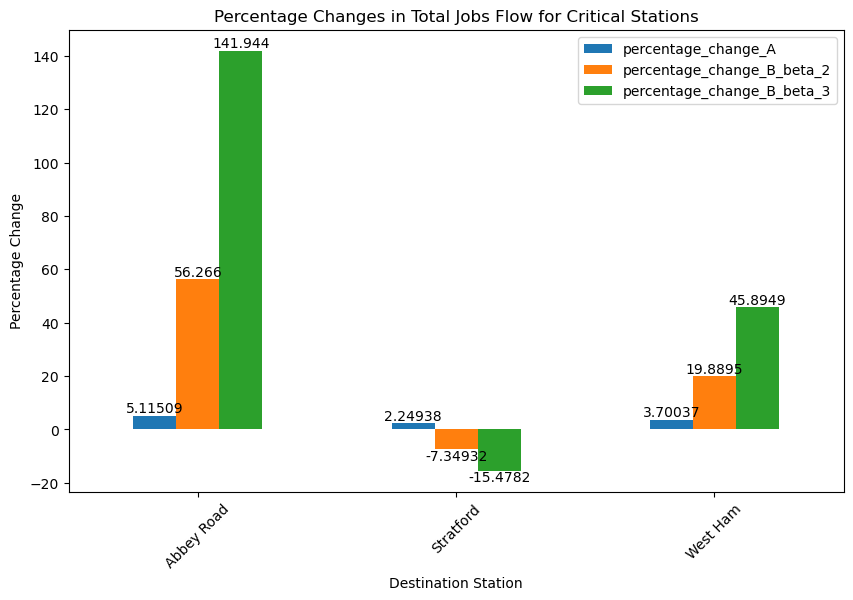

In [64]:
# Filter the data for the critical stations
critical_stations = ['West Ham', 'Abbey Road', 'Stratford']
filtered_data = data[data['station_destination'].isin(critical_stations)]

# Calculate the total flows before and after each scenario for each critical station
total_flows = filtered_data.groupby('station_destination').agg({'prodsimest1': 'sum', 'prodsimest4': 'sum', 'prodsimest5': 'sum', 'prodsimest6': 'sum'}).reset_index()

# Calculate the percentage of change
total_flows['percentage_change_A'] = ((total_flows['prodsimest4'] - total_flows['prodsimest1']) / total_flows['prodsimest1']) * 100
total_flows['percentage_change_B_beta_2'] = ((total_flows['prodsimest5'] - total_flows['prodsimest1']) / total_flows['prodsimest1']) * 100
total_flows['percentage_change_B_beta_3'] = ((total_flows['prodsimest6'] - total_flows['prodsimest1']) / total_flows['prodsimest1']) * 100

# Plot the percentage change of the total jobs flow for each critical station
fig, ax = plt.subplots(figsize=(10, 6))
bars = total_flows.plot(x='station_destination', y=['percentage_change_A', 'percentage_change_B_beta_2', 'percentage_change_B_beta_3'], kind='bar', ax=ax)

# Add the percentage change values on top of each bar
for container in bars.containers:
    bars.bar_label(container)

plt.ylabel('Percentage Change')
plt.xlabel('Destination Station')
plt.title('Percentage Changes in Total Jobs Flow for Critical Stations')
plt.xticks(rotation=45)
# Save the figure with a title
plt.savefig('IV_3_2.png', bbox_inches='tight', dpi=300)
plt.show()